# MULTIVARIATE TIME SERIES MODELING
# Agriculture and pasture land area historical serie for cities in Pará, Brazil
---
# 0. Importing Modules

In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(999)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings('ignore')
import tools # Custom modules
from time_series_modeling import (
    model, model_selection,
    series_model, sequence_scorer
)

---
# 1. Processing data

In [2]:
# 1.1 Loading processed data
data = pd.read_csv('data/clean/data.csv') # clean provided data
series = tools.preprocess.load_series(path='data/clean/series/') # dict of pandas series 
X = pd.read_csv('data/clean/series.csv', index_col=0) # dataframe of series as columns
# 1.2 Defining target variable name
target = 'area'
# 1.3 Extracting target values as pandas series indexed by integer encoded years
# Excluding series with less than n_min=3 values
lab_series = tools.preprocess.get_lab_series(series, data, target, index_col='year', n_min=3)
keys = list(lab_series.keys())
# 1.4 Extracting target values as pandas series indexed by integer encoded years
# Excluding series with less than n_min=2 values
# including index colum in 'lab_ind_index' dataframes to reference each observation
lab_ind_series = tools.preprocess.get_lab_indexed_series(series, data, cols=['index', target], index_col='year', n_min=3)
ind_keys = list(lab_ind_series.keys())
# 1.5 product and product type category values
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava', 'Corn', 'Soy', 'Sorghum', 'Cocoa',
    'Palm oil', 'Açaí', 'Livestock', 'Others-temporary', 'Others-permanent'
]
# 1.6 Extracting indexes of each product
prod_indexes = tools.category_index.get_ctgr_combs_indexes(data, prods)
# 1.7 Extracting indexes of each product type
prodtype_indexes = tools.category_index.get_ctgrs_indexes(data)

Done! Loaded 1107 files.


---
# 2. Choosing models

In [3]:
regressors_names = [
    'AdaBoostRegressor', 'BaggingRegressor', 'BayesianRidge', 'DecisionTreeRegressor',
    'DummyRegressor','ElasticNet', 'ExtraTreeRegressor', 'ExtraTreesRegressor',
    'GaussianProcessRegressor', 'GradientBoostingRegressor', 'HistGradientBoostingRegressor',
    'KernelRidge','Lars','Lasso','LassoLars', 'LassoLarsIC','LinearRegression', 'LinearSVR',
    'MLPRegressor','NuSVR', 'OrthogonalMatchingPursuit','PassiveAggressiveRegressor',
    'PoissonRegressor', 'RandomForestRegressor','Ridge','RidgeCV','SVR', 'TheilSenRegressor',
    'TransformedTargetRegressor','TweedieRegressor'
]
# list of time series specialized models
specialized_models = ['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima']

# define analysis params dict
analysis_params = {
    'models_names': regressors_names + specialized_models,
    'keys': list(np.random.choice(keys, 100, replace=False)),
    'test_size': 2,
    'min_train_size': 1,
}
# save and load dict as json file
# json.dump(analysis_params, open('data/analysis_params.json', 'w'))
analysis_params = json.load(open('data/analysis_params.json', 'r'))

---

# 3. Predicting and scoring each model for each time serie for different training sizes

### 3.1 Instantiating model class object

In [4]:
ts_model = model(
    series=lab_series,
    ** analysis_params
)

### 3.2 Grid scoring models for each time serie for different training sizes

In [5]:
keys_models_lc = ts_model.score_keys_models(
    path='scores/',
    filename='scores.csv',
    path_partial='partial/',
    verbose=1,
)

Keys scored: 100/100 - scores.csv


### 3.3 Concatenating partial scores (Optional)

In [6]:
# scrs = model_selection.concat_partial_scrs('scores/partial/')
# scrs.to_csv('scores/scores.csv', index=True)

### 3.4 Reloading and printing models scores results

In [7]:
scrs = pd.read_csv('scores/scores.csv', index_col=0)
display(scrs.sample(5)); scrs = None

,mae,mse,mape,wape,r2,mpe,model,key
train size,,,,,,,,
15,1683.918079,3.391360e+06,1.938423,1.118882,-4.233379,1.938423,TweedieRegressor,7f076b180f941ec8-Others-temporary
4,12744.138945,2.000673e+08,0.179834,0.179422,-1777.170719,0.179834,TheilSenRegressor,b0e4b4b27117562a-Livestock
7,2.732143,9.163903e+00,0.606505,0.496753,-3.072846,0.606505,TransformedTargetRegressor,051e9cc7d7636816-Others-permanent
7,22.500000,8.071438e+02,0.115824,0.105882,-0.594358,0.115824,GradientBoostingRegressor,13804a196311e1ba-Beans
12,7204.583333,5.215602e+07,3.043576,2.881833,-207.624084,3.043576,LassoLarsIC,855f882ce507aba5-Corn


---

# 4. Selecting models based on scores and additional parameters

In [8]:
selector = model_selection()

model_selection_params = json.load(open('data/model_selection_params.json', 'r'))
keys_models_maps = selector.model_selection_optimization(
    model_selection_params,
    scrs_path='scores/scores.csv', scrs=None,
    save_path='models/default_analysis/', verbose=0,
)

Done! Saved 6 key-model maps.


### 4.2 Reloading and printing individual model composition
#### Selected models for 1st ten series, for specific combination of params

In [9]:
default_model = json.load(open('models/default_analysis/default.json'))
display(dict(list(default_model.items())[:10])); default_model = None

{'9ce50fa197613de1-Cassava': 'ARIMA',
 'fa005e1ffef6032a-Others-permanent': 'AdaBoostRegressor',
 '746cc42bfb8f6b62-Others-temporary': 'AutoReg',
 'f4612b8b5a8223b5-Beans': 'DecisionTreeRegressor',
 'be8a37473dc63db0-Soy': 'SARIMAX',
 'be4424aa54f8d2ae-Rice': 'AdaBoostRegressor',
 '783dbed4df67af9f-Others-temporary': 'AdaBoostRegressor',
 'b0e4b4b27117562a-Livestock': 'AutoReg',
 'a51be58f39d1d625-Beans': 'AdaBoostRegressor',
 'd6ffd6d7dfe22d57-Others-permanent': 'DecisionTreeRegressor'}

---
# 5. Predict each sequence of 'test_size' years for each serie for each generated model

In [10]:
Model = series_model(
    lab_ind_series, keys=None, target=target,
    # model_path='models/default_analysis/default.json'  # uncoment and pass 'keys' parameter to predict with single model
)

### 5.2 Predicting sequences for multiple models

In [11]:
# input path to folder of models (key-model maps) and save_path to folder to save predictions
models_preds = Model.maps_predictions(
    x_min=2, x_max=48, test_size=2,
    min_train_size=1, max_train_size=47,
    min_test_size=0, dropna=False,
    path='models/default_analysis/', filter_by='.',  # exclude model files with 'filter_by' keyword
    save_path='predictions/default_analysis/'        #  change 'min_test_size' to zero and 'dropna' to False
)                                                         #  to make future predictions

Predicting with model: 7/7 - weight_order-2


### 5.3 Reloading sequence predictions for model with default parameters

In [12]:
seq_scorer = sequence_scorer()
default_model = json.load(open('models/default_analysis/default.json'))
default_preds = seq_scorer.load_csv_folder('predictions/default_analysis/default/')

In [13]:
preds_0, preds_1 = default_preds_rebuild = seq_scorer.rebuild_prediction_series(
    yhat_i=default_preds,
    model=default_model,
    base_year=1974
)

### 5.4 Printing predictions for all series for specific pair of years (by original dataframe index)

Predictions for 2016-2017 (43th and 44th years of the original series)

In [14]:
default_preds[43]

49892.0      21.000000
50035.0      21.000000
NaN         100.000000
43026.0     100.000000
49858.0     518.000000
              ...     
50100.0     258.346554
41169.0      50.000000
43728.0      50.000000
41107.0    2000.000000
43666.0    2000.000000
Name: 0, Length: 178, dtype: float64

### 5.4 Printing one step predictions for specific serie (indexed by year)

The step of the prediction refers to how many years ahead the predicted value is from the last value known by the model that made the prediction (last training value).

In [15]:
preds_0['cead2cbd1f8f0b86-Soy'].dropna()

2016    111.443612
2017     88.412596
2018    291.666667
2019    291.666667
2020    291.666667
Name: cead2cbd1f8f0b86-Soy, dtype: float64

---

# 6. Scoring models' prediction sequences by category

In [16]:
Ytrue = data[target].dropna()

seq_scorer = sequence_scorer(
    Ytrue, target, criteria='wape', avg=False,
    metrics=['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
    indexes=prodtype_indexes
)

In [17]:
default_analysis_scrs = seq_scorer.score_models_prediction_sequences(preds_path='predictions/default_analysis/', filter_by='.')

7/7 - Loading file: weight_order-2


---

# 7. Visualizing and comparing models performances

### 7.1 Average wape between product type categories for predition of pair pair of years

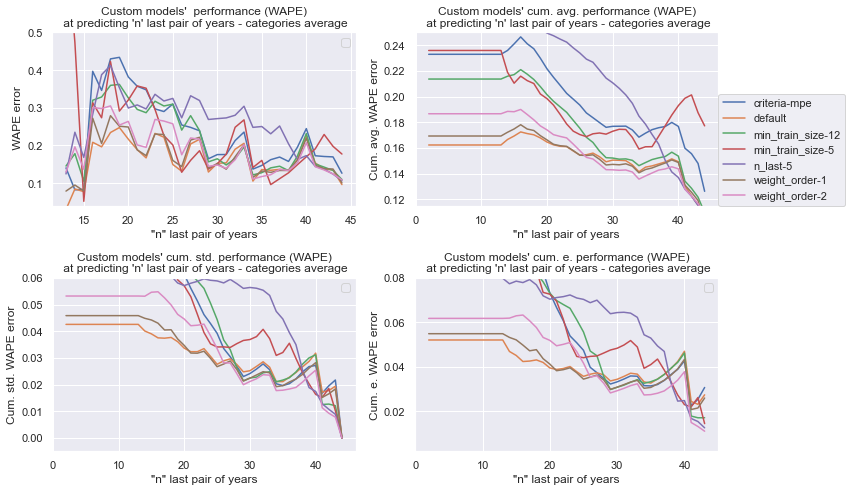

In [18]:
seq_scorer.plot_models_sequence_scrs(
    default_analysis_scrs, figsize=(12, 7),
    legend=False, leg_loc=(1,0), leg_i=1,
    ylim=[(0.04, 0.5), (0.115, 0.25), (-0.005, 0.06), (0.002, 0.08)],
)

### 7.2 Wape for product type "temporary" for predition of each pair of years

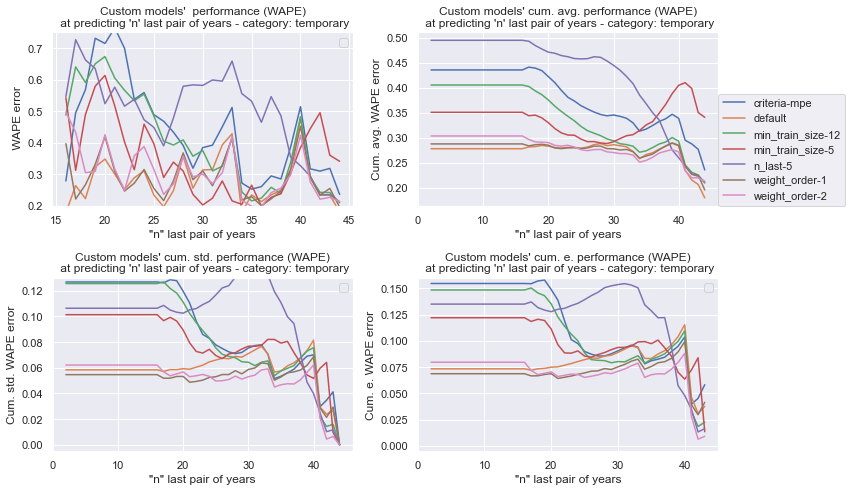

In [19]:
seq_scorer.plot_models_sequence_scrs(
    default_analysis_scrs, category='temporary', figsize=(12, 7),
    legend=False, leg_loc=(1,0), leg_i=1,
    ylim=[(0.2, 0.75), (None, None), (-0.005, 0.13), (-0.005, 0.16)],
)

### 7.3 Wape for product type "permanent" of predition of eadch pair of years

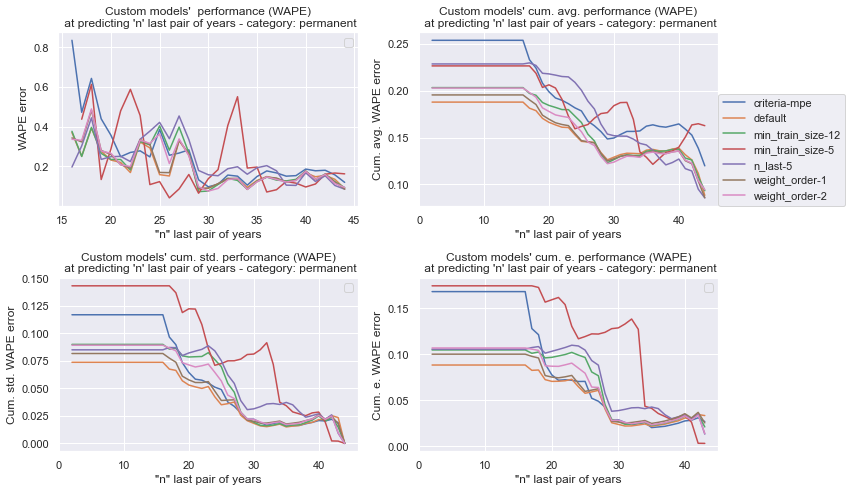

In [20]:
seq_scorer.plot_models_sequence_scrs(
    default_analysis_scrs, category='permanent', figsize=(12, 7),
    legend=False, leg_loc=(1,0), leg_i=1
)

### 7.4 Wape for product type "pasture" of predition of each pair of years

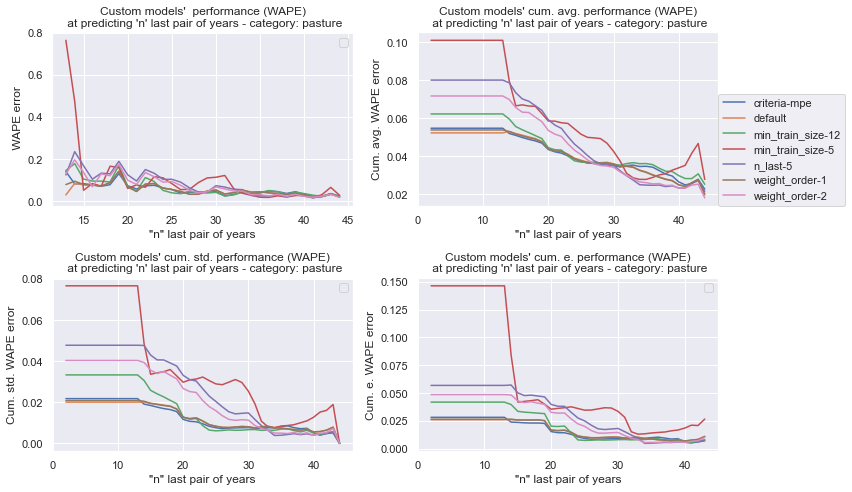

In [21]:
seq_scorer.plot_models_sequence_scrs(
    default_analysis_scrs, category='pasture', figsize=(12, 7),
    legend=False, leg_loc=(1,0), leg_i=1
)

---

# 8. Visualizing final model predictions

### 8.1 Reloading selected model predictions

In [22]:
pred_path = 'predictions/default_analysis/default/'
model_path = 'models/default_analysis/default.json'
yhat_i = sequence_scorer().load_csv_folder(pred_path)
default_model = json.load(open(model_path))

### 8.2 Model composition

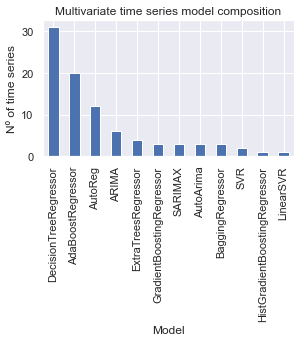

In [23]:
fig, ax = plt.subplots(figsize=(4.5,2.5), tight_layout=True)
pd.Series(default_model).value_counts().plot.bar(title='Multivariate time series model composition')
plt.xlabel('Model'); plt.ylabel('Nº of time series');plt.show(); 

### 8.3 Random sample series real vs predicted values (one and two steps predictions)

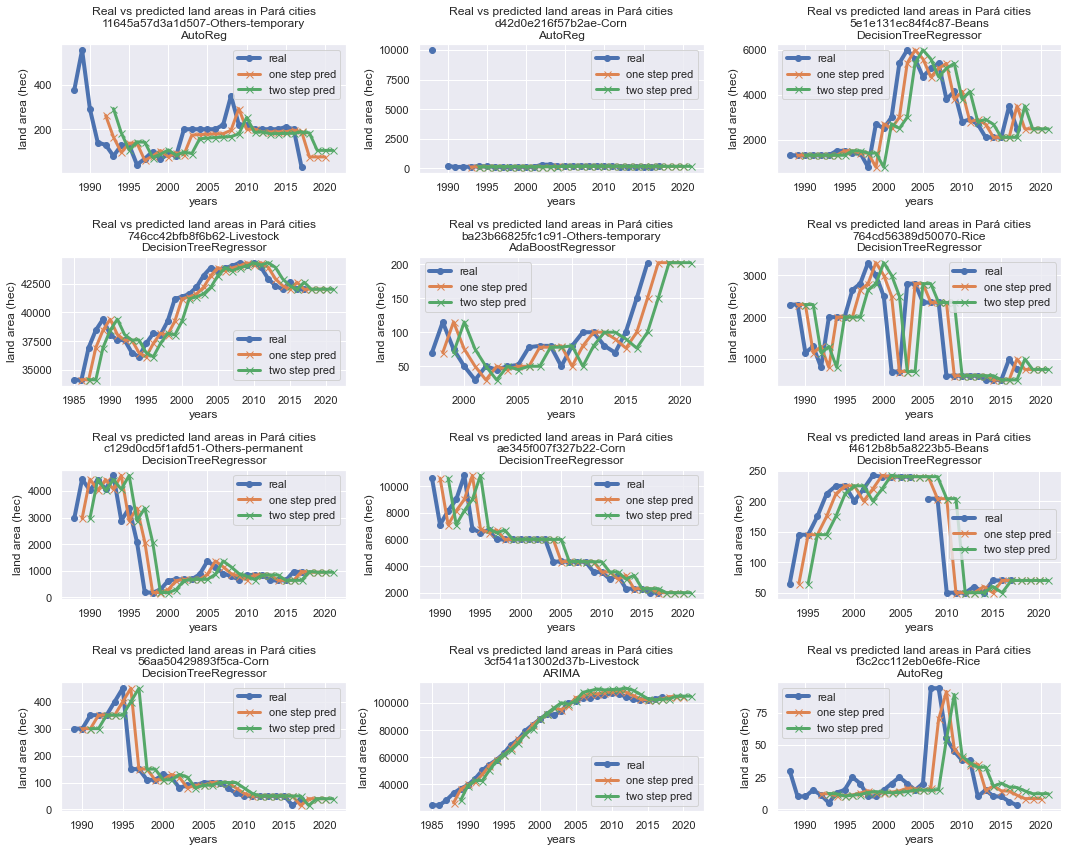

In [24]:
sequence_scorer().plot_random_pred(
    X, default_model, yhat_i,
    exclude=[], n_series=12, n_cols=3, figsize=[5, 3],
    X_params={'marker': 'o', 'ms': 6, 'lw': 4},
    X0_params={'marker': 'x', 'ms': 7, 'lw': 3},
    X1_params={'marker': 'x', 'ms': 7, 'lw': 3},
    save_path='plots/',
    filename='predictions.jpg'    
)